# Investigate a Sample

### First run this cell

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *
import json
import itertools

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 

def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 



###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size) :
        self.images = images
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_img
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img

def remove_background(sample, thresh = 500, old_tag=None, new_tag=None,blanker = 30):
    d = sample.raw_data.data.copy()
    d_shape = d.shape
    n_shape, p_shape = d_shape[0:2], d_shape[2:]
    ps0 = p_shape[0] //2
    try:
        d[:,:,ps0- blanker:ps0 + blanker, ps0 - blanker: ps0 + blanker] = np.zeros((2*blanker,2*blanker))
    except:
        d = d.compute()
        d[:,:,ps0- blanker:ps0 + blanker, ps0 - blanker: ps0 + blanker] = np.zeros((2*blanker,2*blanker))
    maskx, masky = np.where(d.sum(axis=(2,3))<thresh)
    if old_tag !=None:
        clustmap = sample.all_maps[old_tag].copy()
        clustmap += 1
        clustmap[maskx, masky] = 0 
        newmap = np.zeros_like(clustmap)
        for i, o in enumerate(np.unique(clustmap)):
            newmap[np.where(clustmap == o)] = i
        newmap += 1
        if new_tag != None:
            sample.all_maps[new_tag] = newmap
        return newmap
    else:
        return np.where(d.sum(axis=(2,3))<thresh, 0, 1)

def show_cluster_patterns(sample, tag):
    uis = np.unique(sample.all_maps[tag])
    od = np.zeros((uis.size, 512, 256))
    for x,i in enumerate(uis):
        p = resize(sample.all_patterns[tag][i-1], (256,256))
        n = resize(np.where(sample.all_maps[tag] == i, p.max(), 1), (256,256))
        p[0,:] = p.max()
        o = np.concatenate([n,p], axis = 0)
        od[x] = o
    return hs.signals.Signal2D(od)

def signal_boosted_scan(sample, tag):
    uts = np.unique(sample.all_maps[tag])
    blank = np.zeros_like((sample.raw_data))
    blank = blank.astype('float32')
    for t in uts:
        blank[np.where(sample.all_maps[tag]==t)] = sample.all_patterns[tag][t]
    return hs.signals.Signal2D(blank)

def inv_sbs(sbs, tag = 'vl_vae', sp = (0,0), return_fig = False, interactive = True, **kwargs):
    sbsg = np.repeat(sbs.data.sum(axis= (2,3))[:,:,None],3, -1)
    sbsg /= sbsg.max()
    
    def boost(array):
        return np.log10(np.log10(array+1)+1)

    def format_ax():
        ax[0].set_frame_on(False)
        #ax[1].set_frame_on(False)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]}, figsize=(8,8))
    
    
    clust = sample.all_maps[tag][sp[0],sp[1]]

    clust_loc = np.where(sample.all_maps[tag] == clust)

    new_nav = sbsg.copy()

    new_nav[clust_loc] = np.array([0.1254902 , 0.69803922, 0.66666667])
    
    
    ax[0].imshow(new_nav)
    ax[1].imshow(boost(sbs.data[sp[0],sp[1]]), cmap= 'gray', **kwargs)

    format_ax()
    
    if interactive == True:
    
        global coords
        coords = []

        def onclick(event):
            global ix, iy
            ix, iy = np.round(event.xdata,0), np.round(event.ydata,0)
            print(ix, iy)

            coords.append((ix, iy))

            ax[0].clear()
            ax[1].clear()

            clust = sample.all_maps[tag][int(iy),int(ix)]

            clust_loc = np.where(sample.all_maps[tag] == clust)

            new_nav = sbsg.copy()

            new_nav[clust_loc] = np.array([0.1254902 , 0.69803922, 0.66666667])



            ax[0].imshow(new_nav)
            ax[1].imshow(boost(sbs.data[int(iy),int(ix)]), cmap = 'gray', **kwargs)

            format_ax()

            ax[0].draw()
            ax[1].draw()


            return coords

        cid = fig.canvas.mpl_connect('button_press_event', onclick)

    if return_fig == True:
        return fig
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2022-03-23 11:00:59.252561: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Check the GPU can be found

In [2]:
tf.__version__

'2.3.0'

In [3]:
tf.config.list_physical_devices()

2022-03-23 11:01:26.020141: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-03-23 11:01:26.021279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-23 11:01:26.021306: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-23 11:01:26.032723: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-23 11:01:26.042638: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-03-23 11:01:26.052670: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-03-23 11:01:26.059906: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolv

### Select your data set

In [4]:
dp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/SimulatedDS-data.hdf5')

### Set the Model Path

In [5]:
mp = dp.redirect('Final_Models')
mp

Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/Final_Models')

### Create a ProcessedSample Object

In [6]:
sample = ProcessedSample(dp, 'Test')

[########################################] | 100% Completed |  4.4s


<IPython.core.display.Javascript object>


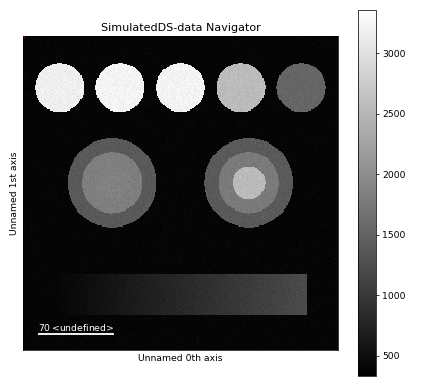

<IPython.core.display.Javascript object>


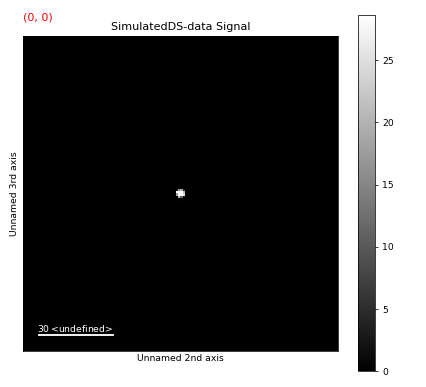

In [7]:
sample.raw_data.plot()

### Pre-process the data to speed up later functions (can avoid this if there are memory constraints)

In [8]:
sample.save_ml_manipulation('full_ds', data_manip_lowq, 128)

dask to numpy
dask to numpy done
started data manipulations
resized


## Set the hparams, can pull these out of the info dictionary

In [9]:
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

In [10]:
sample.set_model_data('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Models/New','cnn',hparams['LAT'],use_generic_model = True)

### Check the model has built

In [11]:
model = create_vae_model(hparams)
model.summary()

2022-03-23 11:01:49.489755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 11:01:49.502705: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-03-23 11:01:49.507911: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557483598590 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-23 11:01:49.507942: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-23 11:01:49.621566: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5574836050f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-03-23 11:01:49.

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    [(None, 2), (None, 2), (N 3654660   
_________________________________________________________________
functional_3 (Functional)    (None, 128, 128, 1)       3394817   
Total params: 7,049,477
Trainable params: 7,049,477
Non-trainable params: 0
_________________________________________________________________


### Load in the trained weights

best_model = mp.walk('.hdf5')[1]
best_model

In [12]:
model.load_weights('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/FullModel/chk-440-4.26092e+01.hdf5')

### You now need to set the model to the sample 

In [13]:
sample.set_model(model)

### You can encode the data you pre-processed earlier (or will default to sample.raw_data)

In [14]:
sample.encode('vae',input_data_tag='full_ds', bn= 64)

2022-03-23 11:01:51.489563: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-03-23 11:01:52.463982: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-03-23 11:01:52.558425: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-03-23 11:01:53.449957: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [15]:
sample.raw_data

<LazySignal2D, title: , dimensions: (296, 295|128, 128)>

### You can inspect the reconstructed image and compare it to the raw data

In [16]:
dim0_info = (0, np.floor(sample.encoded_data[:,0].min()), np.ceil(sample.encoded_data[:,0].max()),200)
dim1_info = (1, np.floor(sample.encoded_data[:,1].min()), np.ceil(sample.encoded_data[:,1].max()),200)

In [17]:
dim0_info

(0, -5.0, 5.0, 200)

(200, 200, 128, 128)


<IPython.core.display.Javascript object>


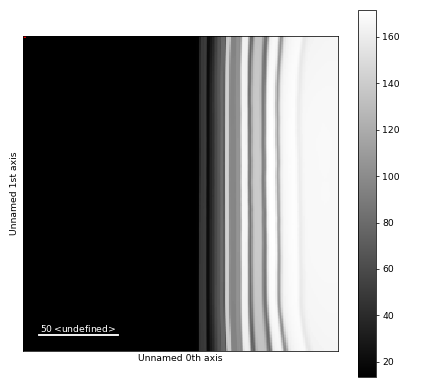

<IPython.core.display.Javascript object>


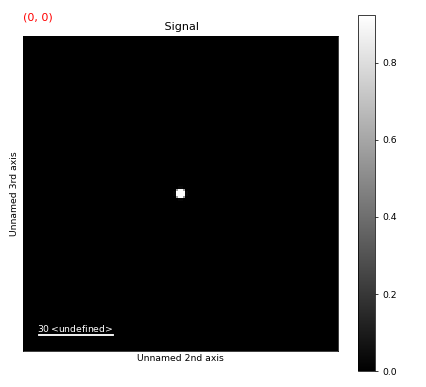

In [18]:
sample.chart_terrain(dim0_info, dim1_info)

In [19]:
from skimage.metrics import structural_similarity as SSI
from skimage.transform import PiecewiseAffineTransform, warp
from sklearn.neighbors import NearestNeighbors as kNN

def get_latgrid(sample, res=100):
    xmin, xmax = np.floor(np.min(sample.encoded_data[:,0])), np.ceil(np.max(sample.encoded_data[:,0]))
    ymin, ymax = np.floor(np.min(sample.encoded_data[:,1])), np.ceil(np.max(sample.encoded_data[:,1]))

    latgrid_res = res

    xgrid, ygrid = np.repeat(np.linspace(xmin, xmax, latgrid_res)[:,None],latgrid_res, axis = 1), np.repeat(np.linspace(ymin, ymax, latgrid_res)[None,:],latgrid_res, axis = 0)

    return np.concatenate([xgrid[:,:,None], ygrid[:,:,None]],axis = 2)

def get_latgrid_free(sample, xmin, xmax, ymin, ymax, res=100):
    latgrid_res = res

    xgrid, ygrid = np.repeat(np.linspace(xmin, xmax, latgrid_res)[:,None],latgrid_res, axis = 1), np.repeat(np.linspace(ymin, ymax, latgrid_res)[None,:],latgrid_res, axis = 0)

    return np.concatenate([xgrid[:,:,None], ygrid[:,:,None]],axis = 2)


def batch_calc_grad(img, radial_kernel, decoded_data, weighting_func, bs=256):
    ssi_ff = []
    n_batches = int(np.ceil(img.shape[0]//bs))
    batches = [img[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    dec_batches = [decoded_data[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    rs_batches = [b.reshape(b.shape[0]*b.shape[1]) for b in batches]
    cart_rs_batches = [np.concatenate([b.real[:,None], b.imag[:,None]], axis = 1) for b in rs_batches]
    for i, batch in enumerate(cart_rs_batches):
        print(i, n_batches)
        nimg = sample.model.decoder(batch).numpy()
        rs_nimg = nimg.reshape((int(nimg.size/(img.shape[1]*128*128)), img.shape[1], 128, 128))
        comp_patterns = dec_batches[i]
        for x, dec_pat in enumerate(comp_patterns):
            grad_ssi = np.asarray([weighting_func(dec_pat, y) for y in rs_nimg[x]])
            ssi_ff.append(np.sum(grad_ssi*radial_kernel))
    return np.asarray(ssi_ff)


def SSI_weighting(img1, img2):
    return 100*SSI(img1,img2)

def get_mobile_points(nn_comp_enc,steps, prev_mp_locs = (), thresh = 'mean', relative_locs = False):
    if thresh == 'mean':
        thresh = np.mean(np.abs(steps))
    if thresh == 'ten':
        thresh = np.max(np.abs(steps))/10
        print(thresh)
        print(np.where(np.abs(steps) > thresh))
    mp_locs = np.where(np.abs(steps) > thresh)
    mobile_points = nn_comp_enc[mp_locs]
    
    if len(prev_mp_locs) != 0:
        n_mp_locs = prev_mp_locs[mp_locs]
        
    if relative_locs == True:

        return mobile_points, n_mp_locs, mp_locs
    else:
        return mobile_points, n_mp_locs

def get_grad_and_decode_data(mobile_points, radial_kernel, r_scale_kernel = False, nn_scale = False):
    if r_scale_kernel ==False:
        grad_points = np.repeat(mobile_points[:,None], radial_kernel.shape[0], axis = 1) + radial_kernel[None, :]
    else:
        if nn_scale == False:
            rf = np.round((np.abs(mobile_points)/np.abs(mobile_points).min()),0).astype('int')
            grad_points = np.repeat(mobile_points[:,None], radial_kernel.shape[0], axis = 1) + r_scale_kernel*rf[:,None]*radial_kernel[None, :]
        else:
            sample_locs = np.concatenate((mobile_points.real[:,None], mobile_points.imag[:,None]), axis = 0)
            nbrs = kNN(n_neighbors=1, algorithm='ball_tree').fit(sample_locs)
            p_sep, indices = nbrs.kneighbors(sample_locs)
            closest = p_sep.min()
            norm_sep = p_sep/closest
            grad_points = np.repeat(mobile_points[:,None], radial_kernel.shape[0], axis = 1) + r_scale_kernel*norm_sep[:,None]*radial_kernel[None, :]

    dec_dat = get_terr_patts(np.concatenate([mobile_points.real[:,None], mobile_points.imag[:,None]],axis = 1))
    return grad_points, dec_dat

def sig_step_from_grad(d_gp, gradient_step, sigz=0.25, sigf=100):
    grad_mag = np.abs(d_gp)

    return sigmoid(grad_mag, sigz, sigf)*gradient_step*(d_gp/grad_mag) 

def norm_step_from_grad(d_gp, factor):
    grad_mag = np.max(np.abs(d_gp))
    
    return (d_gp/grad_mag)*factor 

def sigmoid(z, sigz=0.25, sigf=100):
    x = sigf*(z - sigz)
    return np.exp(-np.logaddexp(0, -x))


def adjust_encoding(mobile_points, grads, comp_enc, mp_locs):
    X,Y  = mobile_points.real, mobile_points.imag

    dX, dY = grads.real, grads.imag
    U, V = X+dX, Y+dY

    moved_points = U+1j*V

    migrated_points = comp_enc.copy()

    migrated_points[mp_locs] = moved_points
    
    return (X,Y), (U,V), migrated_points

def get_terr_patts(img, bs =256):
    n_batches = int(np.ceil(img.shape[0]//bs))
    batches = [img[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    nimg = [sample.model.decoder(batch).numpy() for batch in batches]
    return np.concatenate(nimg, axis = 0).reshape((img.shape[0], 128,128))


def sig_step_from_grad(d_gp, gradient_step, sigz=0.25, sigf=100):
    grad_mag = np.abs(d_gp)

    return sigmoid(grad_mag, sigz, sigf)*gradient_step*(d_gp/grad_mag) 

def sigmoid(z, sigz=0.25, sigf=100):
    x = sigf*(z - sigz)
    return np.exp(-np.logaddexp(0, -x))

def lin_thresh_step(d_gp, thresh, mag = 1):
    scale = np.abs(d_gp)
    return (np.where(scale>thresh, thresh, scale)/thresh)*(d_gp/scale)*mag

def scaled_thresh_step(d_gp, thresh, mobile_points, mag):
    sample_locs = np.concatenate((mobile_points.real[:,None], mobile_points.imag[:,None]), axis = 1)
    nbrs = kNN(n_neighbors=5, algorithm='ball_tree').fit(sample_locs)
    p_sep, indices = nbrs.kneighbors(sample_locs, n_neighbors = 2)
    print(p_sep.shape, p_sep[:,0])
    p_sep = p_sep[:,1]
    closest = p_sep.min()
    norm_sep = p_sep/closest
    
    scale = np.abs(d_gp)
    return (np.where(scale>thresh, thresh, scale)/thresh)*(d_gp/scale)*norm_sep*mag

In [20]:
def sig_step_from_grad(d_gp, gradient_step, sigz=0.25, sigf=100):
    grad_mag = np.abs(d_gp)

    return sigmoid(grad_mag, sigz, sigf)*gradient_step*(d_gp/grad_mag) 

def sigmoid(z, sigz=0.25, sigf=100):
    x = sigf*(z - sigz)
    return np.exp(-np.logaddexp(0, -x))

def lin_thresh_step(d_gp, thresh, mag = 1):
    scale = np.abs(d_gp)
    return (np.where(scale>thresh, thresh, scale)/thresh)*(d_gp/scale)*mag

def scaled_thresh_step(d_gp, thresh, mobile_points, mag):
    sample_locs = np.concatenate((mobile_points.real[:,None], mobile_points.imag[:,None]), axis = 1)
    nbrs = kNN(n_neighbors=5, algorithm='ball_tree').fit(sample_locs)
    p_sep, indices = nbrs.kneighbors(sample_locs, n_neighbors = 2)
    print(p_sep.shape, p_sep[:,0])
    p_sep = p_sep[:,1]
    closest = p_sep.min()
    norm_sep = p_sep/closest
    
    scale = np.abs(d_gp)
    return (np.where(scale>thresh, thresh, scale)/thresh)*(d_gp/scale)*norm_sep*mag


from sklearn.neighbors import KernelDensity
def get_density_net(sample, n_samples, n_bkg_samples, density_approx = 10,  bandwidth=0.5):
    D = sample.encoded_data.copy()
    np.random.shuffle(D)
    D = D[::density_approx]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(D)
    R = kde.sample(n_samples)
    
    
    
    xmin, xmax = np.floor(np.min(sample.encoded_data[:,0])), np.ceil(np.max(sample.encoded_data[:,0]))
    ymin, ymax = np.floor(np.min(sample.encoded_data[:,1])), np.ceil(np.max(sample.encoded_data[:,1]))
    
    print(xmin, xmax,ymin,ymax)
    s_samples = np.random.random((n_bkg_samples, 2))
    
    s_samples[:,0] *= np.abs((xmax - xmin))
    s_samples[:,1] *= np.abs((ymax - ymin))
    s_samples = s_samples + np.array((xmin, ymin))
    
    return np.concatenate((R, s_samples), axis = 0)

import sklearn.metrics.cluster as cmet

def get_map_label_df(map1):
    return np.asarray([np.where(map1 == uinds, 1, 0) for uinds in np.unique(map1)])

def get_cluster_label_overlap(map_pair):
    db1_df,db2_df = map_pair
    label_overlap = np.zeros((db1_df.shape[0], db2_df.shape[0]))
    for i, idf in enumerate(db1_df):
        for j, jdf in enumerate(db2_df):
            label_overlap[i,j] = np.sum(db1_df[i] * db2_df[j])/ np.sum(db1_df[i])
    return label_overlap

def find_map_label(pos, map1):
    return map1[pos]

def get_confidence_from_maps(maps):
    dfs = [x for x in map(get_map_label_df, maps)]

    cluster_overlaps = [x for x in map(get_cluster_label_overlap, [x for x in itertools.permutations(dfs, 2)])]

    overlap_inds = [x for x in itertools.permutations(np.arange(len(maps)), 2)]

    overlap_inds

    len(cluster_overlaps)

    confidence = np.zeros_like(map1, dtype='float32')
    for point in range(len(map1)):
        labels = [i for i in map(find_map_label, np.repeat(point, len(maps)) , maps)]
        total = 0
        for cind, oinds in enumerate(overlap_inds):
            l1, l2 = labels[oinds[0]], labels[oinds[1]]
            total+=cluster_overlaps[cind][l1, l2]
        mean = total/len(overlap_inds)
        confidence[point] = mean
    return confidence



def refine_based_on_density(sample, density_cutoff = -9, n_bulk_samples = 500, sample_grid_res = 200,
                            gn = 0.1,density_approx = 5, bw = 0.4, n_sample_points = 2500, n_bkg_points = 500, 
                            show_net = True, rand_gradient_step = 0.01,rand_n_rsteps = 12, step_scale = 0.01, 
                            step_thresh = 0.001,show_step_size = True, show_net_movement= True, 
                            show_first_refinement = False,n_refine_steps = 200, show_refinement = True, 
                            animate_refinement = True):
    
    '''
    sample: ProcessedSample with the encoded data
    density_cutoff: Cutoff value below which the denisty gradient is ignored (default - -9)
    n_bulk_samples: number of samples to take from the density distribution (default - 500)
    sample_grid_res: The number of grid points to use to approximate the density gradient function (default - 200)
    gn: Gaussian noise maximum magnitude to be added to the randomly sampled density gradient points (default - 0.1)
    density_approx: the number of skips to take of randomly shuffled encoded data to approximate the density (default - 10)
    bw: bandwidth for the density approximation (default - 0.3)
    n_sample_points: number of net points to sample from the density gradient distribution (default - 4000)
    n_bkg_points: number of net points to sample uniformly (default - 1000)
    show_net: Show the positions of the net points (default - True)
    rand_gradient_step: The distance around net points to sample for gradient approximation (default - 0.01)
    rand_n_rsteps: The number of radial samples around net points to sample for grad approx (default - 12)
    step_scale: The magnitude of the largest steps you want in net movement (default - 0.01)
    step_thresh: The gradient cut-off, above which, the step size == step_scale (default - 0.001)
    show_step_size: Show a graph of the distribution of step sizes (default - True)
    show_net_movement: Show how the net points have distorted (default - True)
    show_first_refinement: Show how the sample points have moved after one step (default - True)
    n_refine_steps: Number of refinement steps to run (default - 500)
    show_refinement: Show how the sample points have moved after n steps (default - True)
    animate_refinement: Show an animation of the refinement process (default - True)
    '''
    
    #create a dictionary to hold some data that might be useful to return
    accessory_dict = {}
    
    #get a density based net
    #R = get_density_net(sample, n_sample_points, n_bkg_points, density_approx, bw)
    R = get_density_gradient_net(sample, n_sample_points, density_cutoff, n_bkg_points,n_bulk_samples, density_approx, sample_grid_res,bw, gn)
    
    accessory_dict['net'] = R
    
    #view the point distribution
    if show_net == True:
        plt.figure()
        plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10)
        plt.scatter(R[:,0], R[:,1], s = 20)
    
    #get all the sample points for the gradient 
    rand_latspace = R[:,0] + 1j*R[:,1]
    rand_radial_kernel = rand_gradient_step* np.exp(1j*np.pi*(np.linspace(0, 360, rand_n_rsteps+1)/180))[1:]
    rand_grad_p1, rand_decdat1 = get_grad_and_decode_data(rand_latspace, rand_radial_kernel)
    
    #calculate the gradients
    rand_delta_gp1 = batch_calc_grad(rand_grad_p1, rand_radial_kernel, rand_decdat1, SSI_weighting, 256)
    accessory_dict['grads'] = rand_delta_gp1
    
    #scale the gradients for step sizes
    rand_linsteps = lin_thresh_step(rand_delta_gp1, step_thresh, step_scale)
    if show_step_size == True:
        plt.figure()
        plt.plot(np.sort(np.abs(rand_linsteps)))
    accessory_dict['steps'] = rand_linsteps
    
    #adjust the net points
    rand_op1, rand_np1, rand_current_ps1= adjust_encoding(rand_latspace, rand_linsteps, rand_latspace, np.where(rand_latspace != None))
    accessory_dict['net_displacement'] = rand_np1
    if show_net_movement == True:
        plt.figure(figsize = (8,8))
        plt.scatter(rand_op1[0], rand_op1[1],s =20)
        plt.scatter(rand_np1[0], rand_np1[1],s =20)
        plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.2)
    #refine the points once
    test_data = sample.encoded_data.copy()

    rand_o_latspacer = np.asarray(rand_op1).T
    rand_n_latspacer = np.asarray(rand_np1).T

    rand_tform2 = PiecewiseAffineTransform()
    accessory_dict['transform'] = rand_tform2
    rand_tform2.estimate(rand_n_latspacer, rand_o_latspacer)

    rand_out_data2 = rand_tform2.inverse(test_data)
    
    accessory_dict['first_refinement'] = rand_out_data2.copy()

    if show_first_refinement == True:
        plt.figure()
        plt.scatter(test_data[:,0], test_data[:,1], s =10)
        plt.scatter(rand_out_data2[:,0], rand_out_data2[:,1], s =10)
        
    rand_refine_steps2=[]

    for i in range(n_refine_steps):
        rand_out_data2 = rand_tform2.inverse(rand_out_data2)
        rand_refine_steps2.append(rand_out_data2)
    
    if show_refinement == True:
        plt.figure()
        plt.scatter(test_data[:,0], test_data[:,1], s =10)
        #plt.scatter(out_data[:,0], out_data[:,1], s =10)
        plt.scatter(rand_out_data2[:,0], rand_out_data2[:,1], s =10)
        
    accessory_dict['refinement_steps'] = rand_refine_steps2

    
    if animate_refinement == True:
        # First set up the figure, the axis, and the plot element we want to animate
        figr3, axr3 = plt.subplots()

        axr3.set_xlim(( -1, 1))
        axr3.set_ylim((-1, 1))

        liner3, = axr3.plot([], [], lw=2, ls = '', marker = 'o', alpha = 0.2)

        def init3():
            liner3.set_data([], [])
            return (liner,)
        def animate3(i):
            d3 = rand_refine_steps2[i]
            x3,y3 = d3[:,0], d3[:,1]
            liner3.set_data(x3, y3)
            return (liner3,)
        # call the animator. blit=True means only re-draw the parts that 
        # have changed.
        animr3 = animation.FuncAnimation(figr3, animate3, init_func=init3,
                                       frames=1250, interval=20, blit=True)
        accessory_dict['animation'] = animr3
    return rand_out_data2, accessory_dict
        

## Sample from KDE first derivative

In [21]:
density_approx = 2
bw = 0.025
n_sample_points = 10000
n_bkg_points = 250
n_bulk_samples = 10000
density_cutoff = -9
sample_grid_res = 150
gn = 0.1

In [22]:
density_approx = 2
bw = 0.005
n_sample_points = 10000
n_bkg_points = 10
n_bulk_samples = 10
density_cutoff = -10
sample_grid_res = 800
gn = 0.1

D = sample.encoded_data.copy()

np.random.shuffle(D)

D = D[::density_approx]

D.shape

(43660, 2)

<IPython.core.display.Javascript object>


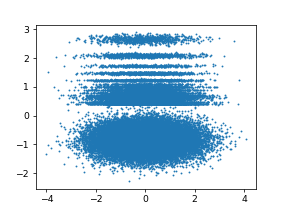

In [23]:
plt.figure()
plt.scatter(D[:,0], D[:,1], s =1)

In [24]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(D)

In [25]:
xgrid = np.linspace(np.floor(D[:,0].min()),np.ceil(D[:,0].max()),sample_grid_res)
ygrid = np.linspace(np.floor(D[:,1].min()),np.ceil(D[:,1].max()),sample_grid_res)
X,Y = np.meshgrid(xgrid, ygrid)
xy = np.vstack((X.ravel(), Y.ravel())).T

xy.shape

Z = kde.score_samples(xy).reshape(X.shape)

dY, dX = np.gradient(Z)

<IPython.core.display.Javascript object>


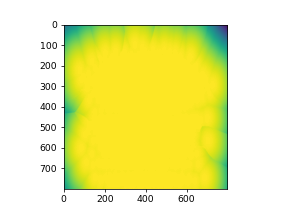

<IPython.core.display.Javascript object>


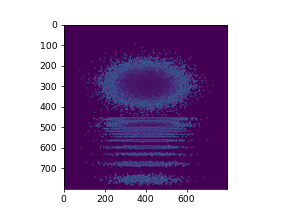

<IPython.core.display.Javascript object>


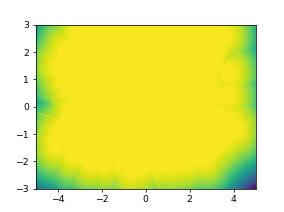

In [26]:
plt.figure()
plt.imshow(Z)

plt.figure()
plt.imshow(np.hypot(dY,dX)*np.where(Z < density_cutoff, 0, 1))

plt.figure()
plt.contourf(X,Y,Z, levels = np.linspace(Z.min(), Z.max(), 50))

In [27]:
dZ = np.hypot(dY,dX)*np.where(Z < density_cutoff, 0, 1)
dZ = dZ/np.sum(dZ)
dZ = dZ.reshape(xy.shape[0])

In [28]:
nitems = n_sample_points


In [29]:
def get_density_gradient_net(D, n_samples, density_cutoff, n_bkg_samples, n_bulk_samples, density_approx = 10, sample_grid_res = 200, bandwidth=0.5, gn = 0.1):
    np.random.shuffle(D)
    D = D[::density_approx]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(D)
    R = kde.sample(n_bulk_samples)
    
    xgrid = np.linspace(np.floor(D[:,0].min()),np.ceil(D[:,0].max()),sample_grid_res)
    ygrid = np.linspace(np.floor(D[:,1].min()),np.ceil(D[:,1].max()),sample_grid_res)
    X,Y = np.meshgrid(xgrid, ygrid)
    xy = np.vstack((X.ravel(), Y.ravel())).T

    Z = kde.score_samples(xy).reshape(X.shape)

    dY, dX = np.gradient(Z)
    
    dZ = np.hypot(dY,dX)*np.where(Z < density_cutoff, 0, 1)

    dZ = dZ/np.sum(dZ)

    dZ = dZ.reshape(xy.shape[0])

    draw = np.random.choice(np.arange(xy.shape[0]), n_samples,
                  p=dZ, replace = True)

    kdgrad = xy[draw] + gn*(np.random.random((n_samples, 2))-0.5*np.ones((n_samples, 2)))
    
    
    
    xmin, xmax = np.floor(np.min(sample.encoded_data[:,0])), np.ceil(np.max(sample.encoded_data[:,0]))
    ymin, ymax = np.floor(np.min(sample.encoded_data[:,1])), np.ceil(np.max(sample.encoded_data[:,1]))
    
    print(xmin, xmax,ymin,ymax)
    s_samples = np.random.random((n_bkg_samples, 2))
    
    s_samples[:,0] *= np.abs((xmax - xmin))
    s_samples[:,1] *= np.abs((ymax - ymin))
    s_samples = s_samples + np.array((xmin, ymin))
    
    return np.concatenate((kdgrad, s_samples, R), axis = 0)

In [30]:
R = get_density_gradient_net(sample.encoded_data.copy(), n_sample_points, density_cutoff, n_bkg_points,n_bulk_samples, density_approx, sample_grid_res,bw, gn)

-5.0 5.0 -3.0 3.0


<IPython.core.display.Javascript object>


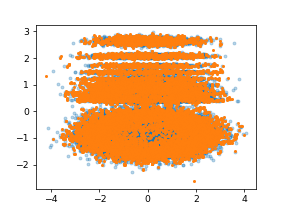

In [31]:
plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.3)
plt.scatter(R[:,0], R[:,1], s = 5, alpha = 1 )

In [32]:
from scipy.spatial import Delaunay

In [33]:
R_moves =  (rand_np1, rand_op1)

NameError: name 'rand_np1' is not defined

In [34]:
def latspace_from_R(R):
    return R[:,0] + 1j*R[:,1]

def get_mesh_gradients(R, rand_gradient_step, rand_n_rsteps):
    rand_latspace = latspace_from_R(R)

    rand_radial_kernel = rand_gradient_step* np.exp(1j*np.pi*(np.linspace(0, 360, rand_n_rsteps+1)/180))[1:]

    rand_grad_p1, rand_decdat1 = get_grad_and_decode_data(rand_latspace, rand_radial_kernel)

    return batch_calc_grad(rand_grad_p1, rand_radial_kernel, rand_decdat1, SSI_weighting, 256)

def get_mesh_transform(R, rand_linsteps):
    rand_latspace = latspace_from_R(R)
    rand_op1, rand_np1, rand_current_ps1= adjust_encoding(rand_latspace, rand_linsteps, rand_latspace, np.where(rand_latspace != None))

    rand_o_latspacer = np.asarray(rand_op1).T
    rand_n_latspacer = np.asarray(rand_np1).T

    rand_tform2 = PiecewiseAffineTransform()
    rand_tform2.estimate(rand_n_latspacer, rand_o_latspacer)
    R_moves =  (rand_np1, rand_op1)
    return rand_tform2, R_moves

def plot_R_movement(sample, R_moves):
    X,Y = (R_moves[1][0], R_moves[1][1])
    U, V = (R_moves[0][0] -  R_moves[1][0], R_moves[0][1]- R_moves[1][1])
    plt.figure(figsize = (8,8))
    plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.2, c = 'grey')
    plt.scatter(X, Y ,s =10, c='blue')
    plt.scatter(R_moves[0][0], R_moves[0][1],s =10, c ='orange')
    plt.quiver(X, Y, U,V)
    
def plot_enc_movement(sample, tform):
    rand_out_data2 = tform.inverse(sample.encoded_data)
    plt.figure()
    plt.scatter(test_data[:,0], test_data[:,1], s =10)
    #plt.scatter(out_data[:,0], out_data[:,1], s =10)
    plt.scatter(rand_out_data2[:,0], rand_out_data2[:,1], s =10)
    
def repeat_tform(tform, n_refine_steps, iter_seq):
    rand_out_data2 = iter_seq[-1]
    import time
    t1 = time.time()
    for i in range(n_refine_steps):
        print(i)
        rand_out_data2 = rand_tform2.inverse(rand_out_data2)
        iter_seq.append(rand_out_data2)
    print(time.time() - t1)
    return iter_seq


def heron(ps):
    p1, p2, p3 = ps
    a, b, c = np.linalg.norm(p2-p1), np.linalg.norm(p3-p2), np.linalg.norm(p1-p3)
    s = (a+b+c)/2
    return np.sqrt(s*(s-a)*(s-b)*(s-c))

def line_interp(p1, p2, nsteps):
    return np.concatenate([np.linspace(p1[0], p2[0], nsteps)[:,None], np.linspace(p1[1], p2[1], nsteps)[:,None]], axis = 1)

def remesh(sample, R, R_moves, density_cutoff, n_movement_bins = 10, area_thresh = None, n_area_bins = 1000, n_line_interp = 10):
    #get current triangulation 
    tri = Delaunay(R)
    #view current triangulation
    plt.figure()
    plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
    plt.triplot(R[:,0], R[:,1], tri.simplices, lw = 1)
    plt.plot(R[:,0], R[:,1], 'o', markersize= 1)
    plt.title('Initial Triangulation')
    #get current mesh movements
    rand_np1, rand_op1 = R_moves
    movement = np.asarray((rand_np1[0] -  rand_op1[0], rand_np1[1]- rand_op1[1])).T
    #get total movement of the simplex vertices
    simp_move = np.sum(np.asarray([np.asarray([np.linalg.norm(movement[x]) for x in simp]) for simp in tri.simplices]), axis = 1)
    #hist these
    plt.figure()
    (n, bins, patches) =  plt.hist(simp_move, n_movement_bins)
    plt.title('Simplex Movement Histogram')
    #Truncate after first bin
    high_m_simps = tri.simplices[np.where(simp_move > bins[1])]
    plt.figure()
    plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
    plt.triplot(R[:,0], R[:,1], high_m_simps, lw = 1)
    plt.title('High Movement Simplices')
    #Get Area of remaining simplices
    simp_area = np.asarray([heron(R[simp]) for simp in high_m_simps])
    plt.figure()
    (n, area_bins, patches) =  plt.hist(simp_area, n_area_bins)
    plt.title('Simplex Area Histogram')
    if area_thresh == None:
        high_a_simps = high_m_simps[np.where(simp_area > area_bins[1])]
    else: 
        high_a_simps = high_m_simps[np.where(simp_area > area_thresh)]
    plt.figure()
    plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
    plt.triplot(R[:,0], R[:,1], tri.simplices, lw = 1)
    plt.triplot(R[:,0], R[:,1], high_a_simps, lw = 1)
    plt.title('Area and Movement Pruned Simplices')
    #For each of the remaining mesh lines, calculate a linear interpolation of sampling points
    line_segs= np.asarray([np.asarray([line_interp(x[0], x[1],n_line_interp) for x in itertools.combinations(R[simps], 2)]) for simps in high_a_simps])
    #and a midpoint to be potentially added to the new mesh
    line_add_points= np.asarray([np.asarray([line_interp(x[0], x[1],3)[1:-1] for x in itertools.combinations(R[simps], 2)]) for simps in high_a_simps])
    #calculate an approximation of real data density at each of the points along the mesh line
    den_seg = np.asarray([[kde.score_samples(lss) for lss in ls] for ls in line_segs])
    #store the min and max value of this density
    den_seg_minmax = np.concatenate((den_seg.min(axis = 2)[:,:,None], den_seg.max(axis = 2)[:,:,None]), axis = 2)
    #calculate the gradient of the change in real data density along the simplex line
    den_seg_grad = np.gradient(den_seg, axis = 2)
    #Find if there is a change in sign of the density (implying a change in character of the underlying point distr)
    #old grad_changes = np.asarray([[(lines.max() * lines.min())> 0 for lines in simps] for simps in den_seg_grad])
    grad_changes = np.asarray([[ np.abs(lines).max() > 5 for lines in simps] for simps in den_seg_grad])
    #If there is a change in sign and the maximum value of the density is sufficently large 
    # ie (the line itself is near points) then add the line to be split
    interesting_lines = []
    for si in range(line_segs.shape[0]):
        for li in range(line_segs.shape[1]):
            if grad_changes[si, li] == True:
                if den_seg_minmax[si,li, 1] > density_cutoff:
                    interesting_lines.append((si, li))
    ilines = np.asarray(interesting_lines)
    i_simps =  high_a_simps[np.unique(ilines[:,0])]
    #get the midpoints of these lines
    refinement_points = flatten_nav(np.asarray([line_add_points[ninds[0], ninds[1]] for ninds in ilines]))
    plt.figure()
    plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
    plt.triplot(R[:,0], R[:,1], high_a_simps, lw = 1)
    plt.triplot(R[:,0], R[:,1], i_simps, lw = 1)
    plt.scatter(refinement_points[:,0], refinement_points[:,1], s = 10, alpha = 1, c = 'black', marker = 'x')
    plt.title('Additional Mesh Points')
    #Add these points to the original points
    Rp = np.concatenate((R, refinement_points), axis = 0)
    #View the new Triangulation
    trip = Delaunay(Rp)
    plt.figure()
    plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
    plt.triplot(Rp[:,0], Rp[:,1], trip.simplices, lw = 1)
    plt.plot(Rp[:,0], Rp[:,1], 'o', markersize= 1)
    plt.title('New Triangulation')
    return (Rp, refinement_points)

In [44]:
tri = Delaunay(R)

<IPython.core.display.Javascript object>


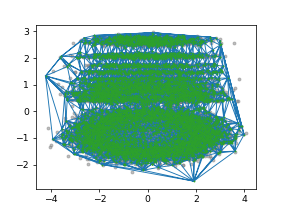

In [45]:
plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
plt.triplot(R[:,0], R[:,1], tri.simplices, lw = 1)

plt.plot(R[:,0], R[:,1], 'o', markersize= 1)


In [46]:
tri.simplices

array([[10003,  2622,  9857],
       [ 8328,  2622, 10003],
       [ 6829,  2537,  6612],
       ...,
       [ 6854,  5204,  2926],
       [ 2059,  5204,  2759],
       [ 5204,  6854,  2759]], dtype=int32)

In [49]:
rand_np1, rand_op1 = R_moves

In [50]:
movement = np.asarray((rand_np1[0] -  rand_op1[0], rand_np1[1]- rand_op1[1])).T

In [51]:
simp_move = np.sum(np.asarray([np.asarray([np.linalg.norm(movement[x]) for x in simp]) for simp in tri.simplices]), axis = 1)


<IPython.core.display.Javascript object>


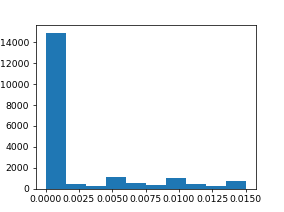

In [52]:
plt.figure()
(n, bins, patches) =  plt.hist(simp_move, 10)

In [53]:
high_m_simps = tri.simplices[np.where(simp_move > bins[1])]

<IPython.core.display.Javascript object>


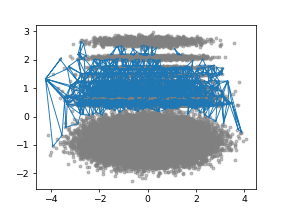

In [54]:
plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
plt.triplot(R[:,0], R[:,1], high_m_simps, lw = 1)

In [117]:
90//90.01

0.0

In [133]:
def heron(ps):
    p1, p2, p3 = ps
    a, b, c = np.linalg.norm(p2-p1), np.linalg.norm(p3-p2), np.linalg.norm(p1-p3)
    s = (a+b+c)/2
    return np.sqrt(s*(s-a)*(s-b)*(s-c))

def cosine_rule(a, b, c):
    return np.arccos(((a**2) +(b**2) - (c**2))/(2*a*b))

def angles(ps):
    p1, p2, p3 = ps
    a, b, c = p2-p1, p3-p2, p1-p3
    al, bl, cl = np.linalg.norm(p2-p1), np.linalg.norm(p3-p2), np.linalg.norm(p1-p3)
    return np.sort([np.rad2deg(x) for x in [cosine_rule(al, bl, cl), cosine_rule(bl, cl, al), cosine_rule(cl,al,bl)]])
    

def line_interp(p1, p2, nsteps):
    return np.concatenate([np.linspace(p1[0], p2[0], nsteps)[:,None], np.linspace(p1[1], p2[1], nsteps)[:,None]], axis = 1)

In [134]:
simp_area = np.asarray([heron(R[simp]) for simp in high_m_simps])
simp_angles =  np.asarray([angles(R[simp]) for simp in high_m_simps])

In [136]:
simp_angles

array([[  0.69922755,   9.7286486 , 169.57212385],
       [ 26.47705688,  69.3097457 ,  84.21319742],
       [  3.55290479,   4.96144935, 171.48564586],
       ...,
       [ 40.24223688,  56.60726937,  83.15049376],
       [ 23.87360882,  74.20157749,  81.92481369],
       [  9.18938127,  72.19241338,  98.61820535]])

In [57]:
simp_area.shape

(5091,)

<IPython.core.display.Javascript object>


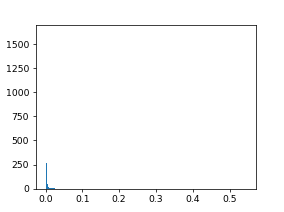

In [58]:
plt.figure()
(n, area_bins, patches) =  plt.hist(simp_area, 1000)

In [138]:
size_inc = np.where(np.where(simp_area > 0.0001, 1, 0) + np.where(simp_angles[:,0] < 15, 1, 0)>0)

In [139]:
high_a_simps = high_m_simps[size_inc]

In [140]:
high_a_simps.shape

(5008, 3)

<IPython.core.display.Javascript object>


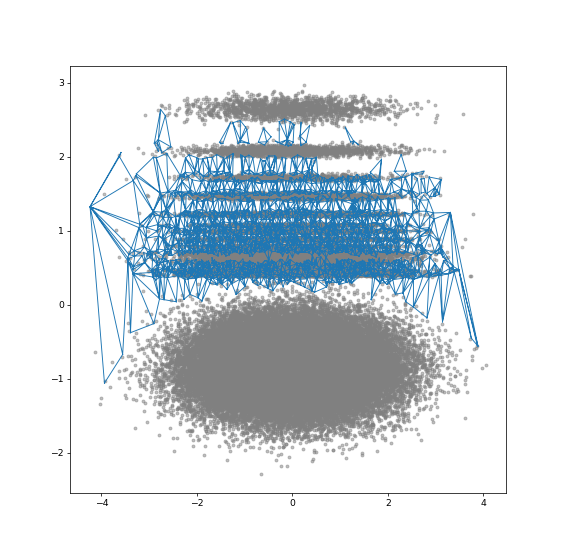

In [141]:
plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
plt.triplot(R[:,0], R[:,1], high_a_simps, lw = 1)

In [125]:
tsimp = R[high_a_simps[1]]

In [126]:
angles(tsimp)

[84.2131974151985, 26.477056882105646, 69.30974570269589]

In [127]:
tsimp[0]

array([-3.33211672,  1.68142033])

In [128]:
tsimp[1]

array([-3.62341958,  2.00541668])

In [129]:
def line_interp(p1, p2, nsteps):
    return np.concatenate([np.linspace(p1[0], p2[0], nsteps)[:,None], np.linspace(p1[1], p2[1], nsteps)[:,None]], axis = 1)

<IPython.core.display.Javascript object>


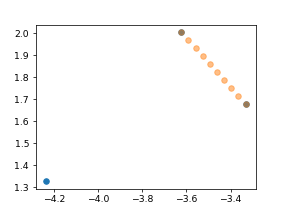

In [130]:
plt.figure()
plt.scatter(tsimp[:,0], tsimp[:,1])
interp_ps = line_interp(tsimp[0], tsimp[1], 10)
plt.scatter(interp_ps[:,0], interp_ps[:,1], alpha = 0.5)

<IPython.core.display.Javascript object>


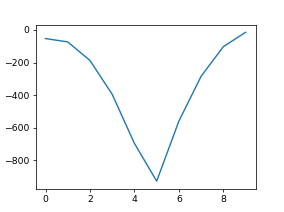

In [131]:
plt.figure()
plt.plot(kde.score_samples(interp_ps))

In [68]:
line_segs= np.asarray([np.asarray([line_interp(x[0], x[1],10) for x in itertools.combinations(R[simps], 2)]) for simps in high_a_simps])

In [69]:
line_add_points= np.asarray([np.asarray([line_interp(x[0], x[1],3)[1:-1] for x in itertools.combinations(R[simps], 2)]) for simps in high_a_simps])

In [70]:
line_add_points.shape

(4872, 3, 1, 2)

In [71]:
line_segs.shape

(4872, 3, 10, 2)

In [72]:
den_seg = np.asarray([[kde.score_samples(lss) for lss in ls] for ls in line_segs])

In [73]:
den_seg_minmax = np.concatenate((den_seg.min(axis = 2)[:,:,None], den_seg.max(axis = 2)[:,:,None]), axis = 2)

In [74]:
den_seg_minmax.shape

(4872, 3, 2)

In [75]:
den_seg_grad = np.gradient(den_seg, axis = 2)

In [95]:
grad_changes = np.asarray([[np.abs(lines).max() > 1 for lines in simps] for simps in den_seg_grad])

In [96]:
grad_changes

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True, False],
       [ True,  True,  True],
       [False,  True,  True]])

In [97]:
interesting_lines = []
for si in range(line_segs.shape[0]):
    for li in range(line_segs.shape[1]):
        if grad_changes[si, li] == True:
            if den_seg_minmax[si,li, 1] > density_cutoff:
                interesting_lines.append((si, li))
ilines = np.asarray(interesting_lines)

In [98]:
i_simps =  high_a_simps[np.unique(ilines[:,0])]

<IPython.core.display.Javascript object>


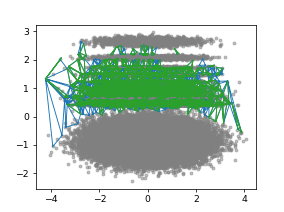

In [99]:
plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
plt.triplot(R[:,0], R[:,1], high_a_simps, lw = 1)
plt.triplot(R[:,0], R[:,1], i_simps, lw = 1)

In [100]:
refinement_points = flatten_nav(np.asarray([line_add_points[ninds[0], ninds[1]] for ninds in ilines]))

In [101]:
refinement_points

array([[-3.60601086,  2.03346474],
       [-2.68528862,  1.52112471],
       [-2.80858095,  1.74960377],
       ...,
       [-1.72840804,  0.77760535],
       [-1.70900777,  0.78263633],
       [-1.71466853,  0.78305628]])

In [102]:
refinement_points.shape

(9613, 2)

<IPython.core.display.Javascript object>


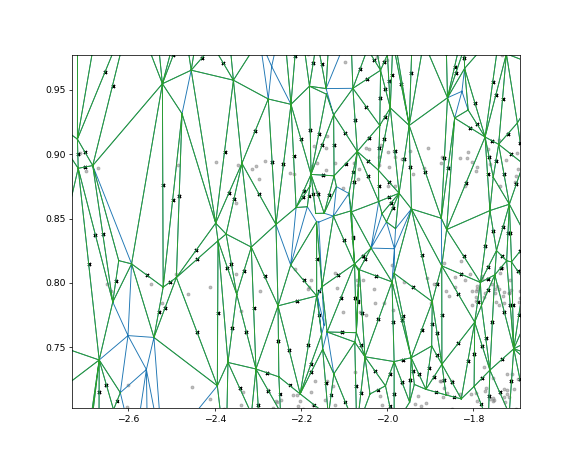

In [103]:
plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
plt.triplot(R[:,0], R[:,1], high_a_simps, lw = 1)
plt.triplot(R[:,0], R[:,1], i_simps, lw = 1)
plt.scatter(refinement_points[:,0], refinement_points[:,1], s = 10, alpha = 1, c = 'black', marker = 'x')

In [451]:
Rp = np.concatenate((R, refinement_points), axis = 0)

In [480]:
trip = Delaunay(Rp)

<IPython.core.display.Javascript object>


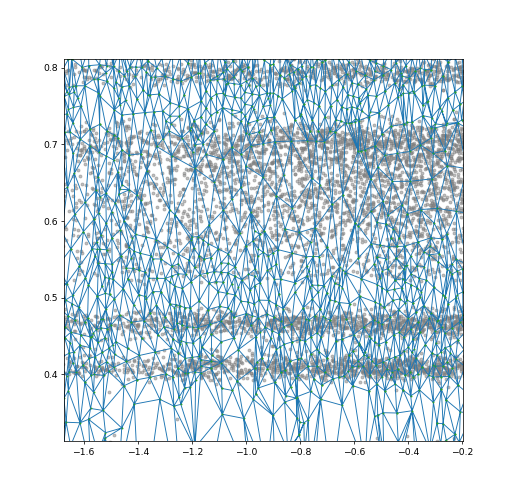

In [481]:
plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
plt.triplot(Rp[:,0], Rp[:,1], trip.simplices, lw = 1)

plt.plot(Rp[:,0], Rp[:,1], 'o', markersize= 1)

In [482]:
trip.simplices

movement = np.asarray((rand_np1[0] -  rand_op1[0], rand_np1[1]- rand_op1[1])).T

simp_move_p = np.sum(np.asarray([np.asarray([np.linalg.norm(movement[x]) for x in simp]) for simp in trip.simplices]), axis = 1)


<IPython.core.display.Javascript object>


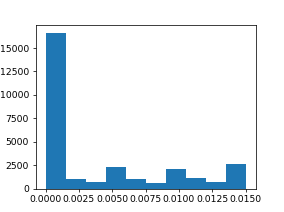

In [483]:
plt.figure()
(n, pbins, patches) =  plt.hist(simp_move_p, 10)

In [484]:
high_m_simps_p = trip.simplices[np.where(simp_move_p > pbins[1])]

In [485]:
simp_area_p = np.asarray([heron(Rp[simp]) for simp in high_m_simps_p])

simp_area_p.shape


(12103,)

<IPython.core.display.Javascript object>


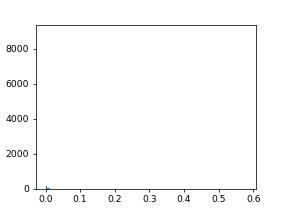

In [486]:
plt.figure()
(n, p_area_bins, patches) =  plt.hist(simp_area_p, 1000)

high_a_simps_p = high_m_simps_p[np.where(simp_area_p > p_area_bins[1])]

In [487]:
high_a_simps_p.shape

(3182, 3)

In [495]:
line_segs_p= np.asarray([np.asarray([line_interp(x[0], x[1],10) for x in itertools.combinations(Rp[simps], 2)]) for simps in high_a_simps_p])

line_add_points_p= np.asarray([np.asarray([line_interp(x[0], x[1],4)[1:-1] for x in itertools.combinations(Rp[simps], 2)]) for simps in high_a_simps_p])

line_add_points_p.shape

line_segs_p.shape

den_seg_p = np.asarray([[kde.score_samples(lss) for lss in ls] for ls in line_segs_p])

den_seg_minmax_p = np.concatenate((den_seg_p.min(axis = 2)[:,:,None], den_seg_p.max(axis = 2)[:,:,None]), axis = 2)

den_seg_minmax_p.shape

den_seg_grad_p = np.gradient(den_seg_p, axis = 2)

grad_changes_p = np.asarray([[(lines.max() * lines.min())< 0 for lines in simps] for simps in den_seg_grad_p])

grad_changes_p

interesting_lines_p = []
for si in range(line_segs_p.shape[0]):
    for li in range(line_segs_p.shape[1]):
        if grad_changes_p[si, li] == True:
            if den_seg_minmax_p[si,li, 1] > density_cutoff:
                interesting_lines_p.append((si, li))
ilines_p = np.asarray(interesting_lines_p)

i_simps_p =  high_a_simps_p[np.unique(ilines_p[:,0])]

refinement_points_p = flatten_nav(np.asarray([line_add_points_p[ninds[0], ninds[1]] for ninds in ilines_p]))

In [496]:
Rpp = np.concatenate((Rp, refinement_points_p), axis = 0)

In [497]:
Rpp.shape

(24234, 2)

<IPython.core.display.Javascript object>


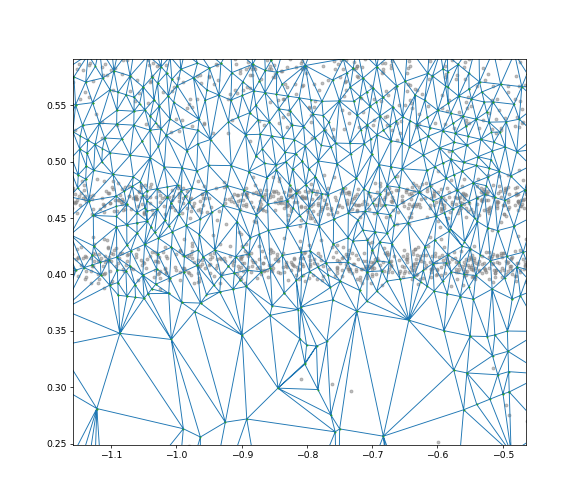

In [498]:
tripp = Delaunay(Rpp)

plt.figure()
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s = 10, alpha = 0.5, c = 'grey')
plt.triplot(Rpp[:,0], Rpp[:,1], tripp.simplices, lw = 1)

plt.plot(Rpp[:,0], Rpp[:,1], 'o', markersize= 1)

# Optimize Parameters

### params:

In [40]:
rand_gradient_step = 0.005
rand_n_rsteps = 12
step_scale = 0.005
step_thresh = 0.0001,

### process:

In [41]:
delta_gp1 = get_mesh_gradients(R, rand_gradient_step, rand_n_rsteps)

0 39
1 39
2 39
3 39
4 39
5 39
6 39
7 39
8 39
9 39
10 39
11 39
12 39
13 39
14 39
15 39
16 39
17 39
18 39
19 39
20 39
21 39
22 39
23 39
24 39
25 39
26 39
27 39
28 39
29 39
30 39
31 39
32 39
33 39
34 39
35 39
36 39
37 39
38 39
39 39


<IPython.core.display.Javascript object>


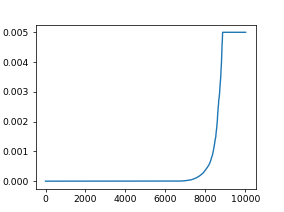

In [42]:
rand_linsteps = lin_thresh_step(delta_gp1, step_thresh, step_scale)

plt.figure()
plt.plot(np.sort(np.abs(rand_linsteps)))

In [43]:
tform, R_moves = get_mesh_transform(R, rand_linsteps)

### Optimise the movement of net points based on steps:

<IPython.core.display.Javascript object>


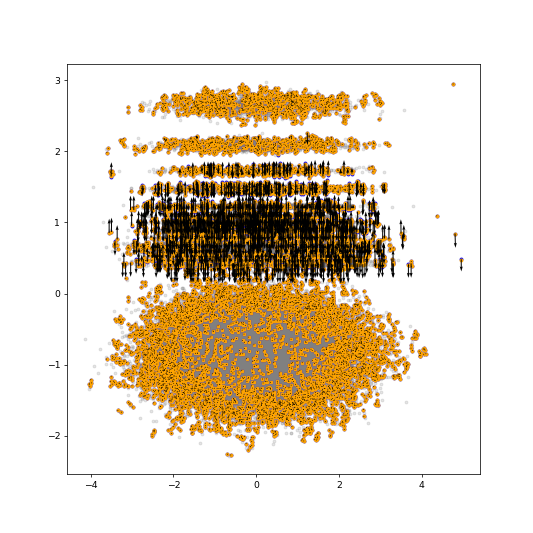

In [619]:
plot_R_movement(sample, R_moves)

### Optimise the effect on the encoded data:

<IPython.core.display.Javascript object>


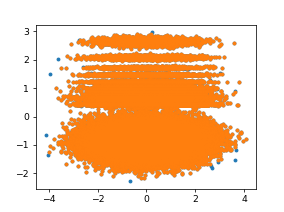

In [620]:
plot_enc_movement(sample, tform )

Next

### params:

In [661]:
n_refine_steps = 15

### process:

In [614]:
refine_steps = [tform.inverse(sample.encoded_data)]

In [616]:
refine_steps = repeat_tform(tform, n_refine_steps, refine_steps)

0
1
2
3
4
30.654499053955078


In [617]:
v = refine_steps[-1]

<IPython.core.display.Javascript object>


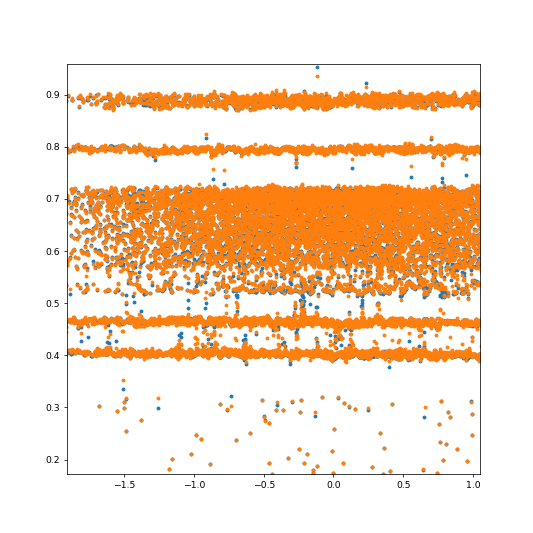

In [618]:
plt.figure(figsize = (8,8))
plt.scatter(rand_refine_steps2[1][:,0], rand_refine_steps2[1][:,1], s =10)
plt.scatter(v[:,0], v[:,1], s =10)

## Probably will want to remesh at this point

If there are odd artifacts where it appears to be bleeding out from an otherwise well defined region, this probably means the mesh is poorly defined around this boundary and some new points are needed. Remeshing can be repeated until this artifacts dissapear

<IPython.core.display.Javascript object>


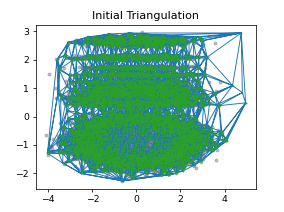

<IPython.core.display.Javascript object>


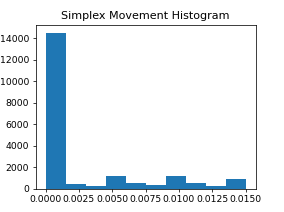

<IPython.core.display.Javascript object>


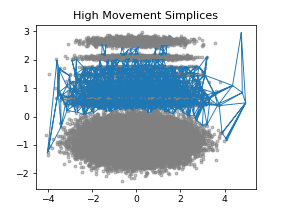

<IPython.core.display.Javascript object>


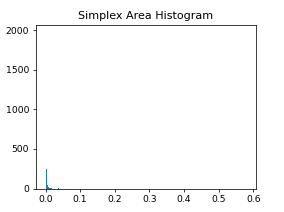

<IPython.core.display.Javascript object>


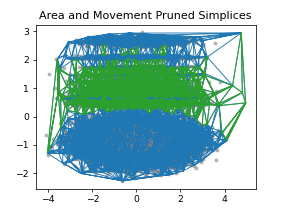

<IPython.core.display.Javascript object>


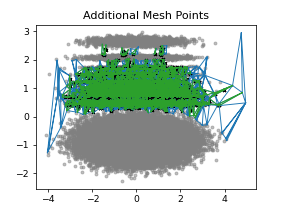

<IPython.core.display.Javascript object>


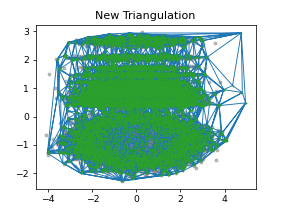

In [621]:
Rp, added_points = remesh(sample, R, R_moves, density_cutoff, n_movement_bins = 10, n_area_bins = 1000, n_line_interp = 10)

In [622]:
Rp_grads = get_mesh_gradients(Rp, rand_gradient_step, rand_n_rsteps)

0 65
1 65
2 65
3 65
4 65
5 65
6 65
7 65
8 65
9 65
10 65
11 65
12 65
13 65
14 65
15 65
16 65
17 65
18 65
19 65
20 65
21 65
22 65
23 65
24 65
25 65
26 65
27 65
28 65
29 65
30 65
31 65
32 65
33 65
34 65
35 65
36 65
37 65
38 65
39 65
40 65
41 65
42 65
43 65
44 65
45 65
46 65
47 65
48 65
49 65
50 65
51 65
52 65
53 65
54 65
55 65
56 65
57 65
58 65
59 65
60 65
61 65
62 65
63 65
64 65
65 65


<IPython.core.display.Javascript object>


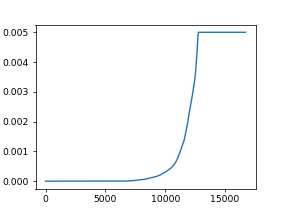

In [624]:
Rp_linsteps = lin_thresh_step(Rp_grads, step_thresh, step_scale)

plt.figure()
plt.plot(np.sort(np.abs(Rp_linsteps)))

In [625]:
tform_Rp, Rp_moves = get_mesh_transform(Rp, Rp_linsteps)

In [662]:
refine_steps_Rp = [tform_Rp.inverse(sample.encoded_data)]

refine_steps_Rp = repeat_tform(tform_Rp, n_refine_steps, refine_steps_Rp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
89.09413695335388


<IPython.core.display.Javascript object>


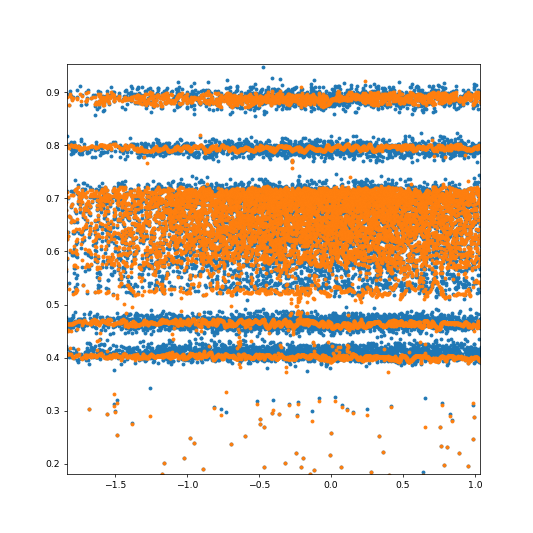

In [663]:
v = refine_steps_Rp[-1]

plt.figure(figsize = (8,8))
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s =10)
plt.scatter(v[:,0], v[:,1], s =10)

#### Second Iteration Remesh

<IPython.core.display.Javascript object>


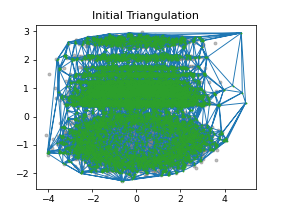

<IPython.core.display.Javascript object>


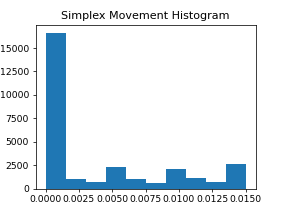

<IPython.core.display.Javascript object>


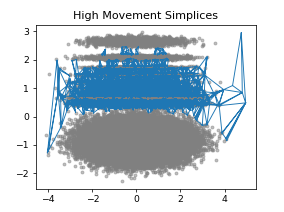

<IPython.core.display.Javascript object>


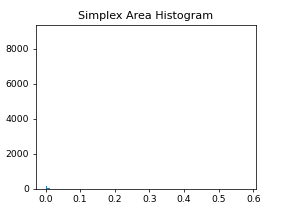

<IPython.core.display.Javascript object>


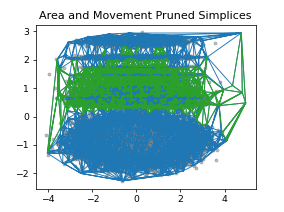

<IPython.core.display.Javascript object>


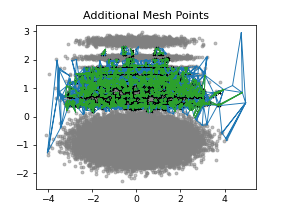

<IPython.core.display.Javascript object>


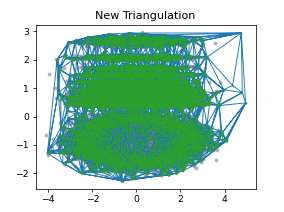

In [633]:
Rpp, Rpp_added_points = remesh(sample, Rp, Rp_moves, density_cutoff, n_movement_bins = 10, n_area_bins = 1000, n_line_interp = 10)

In [648]:
Rpp_added_grads_2 = get_mesh_gradients(Rpp_added_points, rand_gradient_step, rand_n_rsteps)

0 14
1 14
2 14
3 14
4 14
5 14
6 14
7 14
8 14
9 14
10 14
11 14
12 14
13 14
14 14


In [635]:
Rpp_grads = np.concatenate((Rp_grads, Rpp_added_grads))

In [636]:
Rpp_grads_slow = get_mesh_gradients(Rpp, rand_gradient_step, rand_n_rsteps)

0 79
1 79
2 79
3 79
4 79
5 79
6 79
7 79
8 79
9 79
10 79
11 79
12 79
13 79
14 79
15 79
16 79
17 79
18 79
19 79
20 79
21 79
22 79
23 79
24 79
25 79
26 79
27 79
28 79
29 79
30 79
31 79
32 79
33 79
34 79
35 79
36 79
37 79
38 79
39 79
40 79
41 79
42 79
43 79
44 79
45 79
46 79
47 79
48 79
49 79
50 79
51 79
52 79
53 79
54 79
55 79
56 79
57 79
58 79
59 79
60 79
61 79
62 79
63 79
64 79
65 79
66 79
67 79
68 79
69 79
70 79
71 79
72 79
73 79
74 79
75 79
76 79
77 79
78 79
79 79


<IPython.core.display.Javascript object>


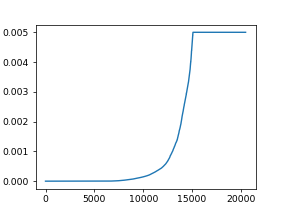

In [656]:
Rpp_linsteps = lin_thresh_step(Rpp_grads, step_thresh, step_scale)

plt.figure()
plt.plot(np.sort(np.abs(Rpp_linsteps)))

In [658]:
tform_Rpp, Rpp_moves = get_mesh_transform(Rpp, Rpp_linsteps)

In [664]:
refine_steps_Rpp = [tform_Rpp.inverse(sample.encoded_data)]

refine_steps_Rpp = repeat_tform(tform_Rpp, n_refine_steps, refine_steps_Rpp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
88.19693350791931


<IPython.core.display.Javascript object>


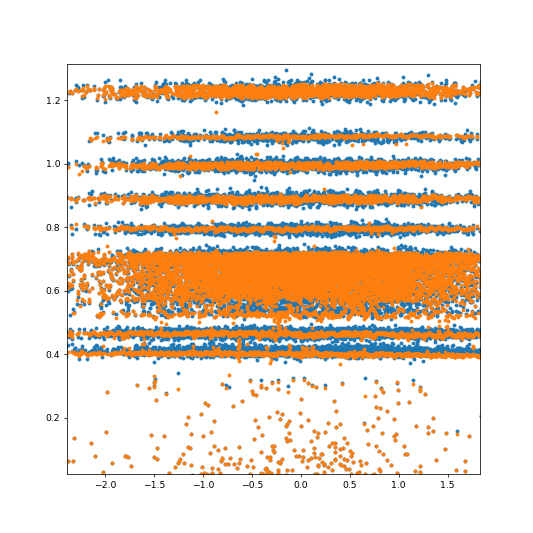

In [666]:
v = refine_steps_Rpp[-1]

plt.figure(figsize = (8,8))
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s =10)
plt.scatter(v[:,0], v[:,1], s =10)

<IPython.core.display.Javascript object>


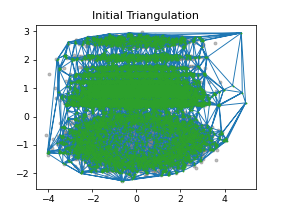

<IPython.core.display.Javascript object>


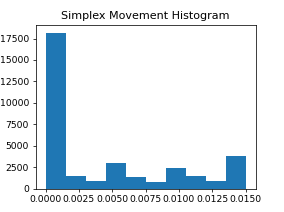

<IPython.core.display.Javascript object>


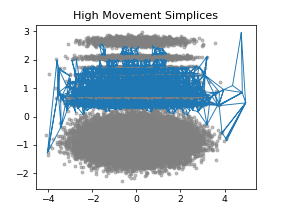

<IPython.core.display.Javascript object>


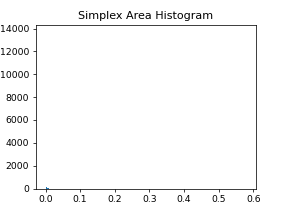

<IPython.core.display.Javascript object>


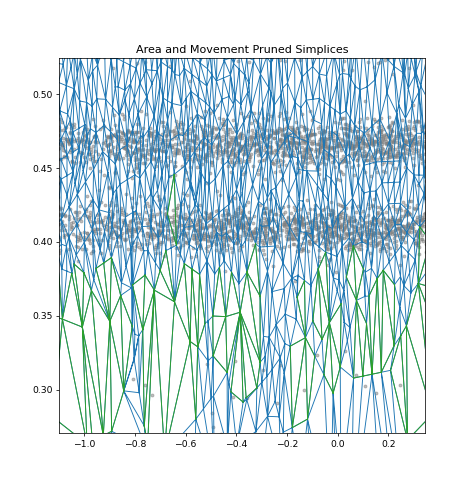

<IPython.core.display.Javascript object>


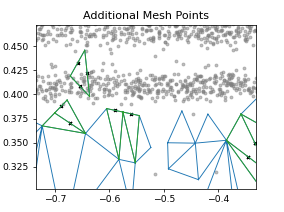

<IPython.core.display.Javascript object>


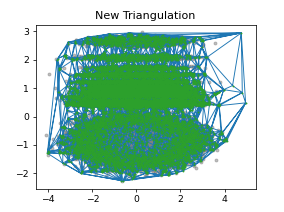

0 3
1 3
2 3
3 3


<IPython.core.display.Javascript object>


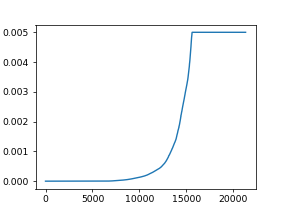

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
86.95741820335388


<IPython.core.display.Javascript object>


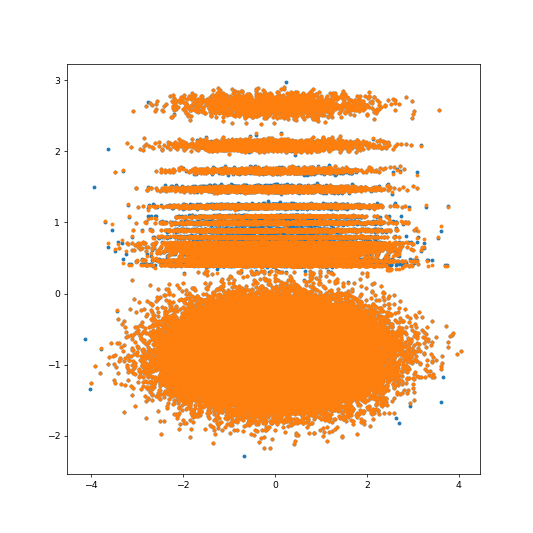

In [667]:
Rppp, Rppp_added_points = remesh(sample, Rpp, Rpp_moves, density_cutoff, n_movement_bins = 10, n_area_bins = 1000, n_line_interp = 10)

Rppp_added_grads = get_mesh_gradients(Rppp_added_points, rand_gradient_step, rand_n_rsteps)

Rppp_grads = np.concatenate((Rpp_grads, Rppp_added_grads))

Rppp_linsteps = lin_thresh_step(Rppp_grads, step_thresh, step_scale)

plt.figure()
plt.plot(np.sort(np.abs(Rppp_linsteps)))

tform_Rppp, Rppp_moves = get_mesh_transform(Rppp, Rppp_linsteps)

refine_steps_Rppp = [tform_Rppp.inverse(sample.encoded_data)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
82.58582043647766


<IPython.core.display.Javascript object>


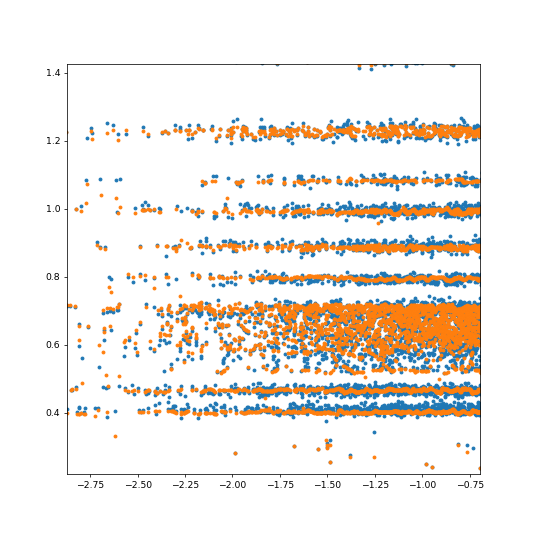

In [669]:
refine_steps_Rppp = repeat_tform(tform_Rppp, n_refine_steps, refine_steps_Rppp)

v = refine_steps_Rppp[-1]

plt.figure(figsize = (8,8))
plt.scatter(sample.encoded_data[:,0], sample.encoded_data[:,1], s =10)
plt.scatter(v[:,0], v[:,1], s =10)

<IPython.core.display.Javascript object>


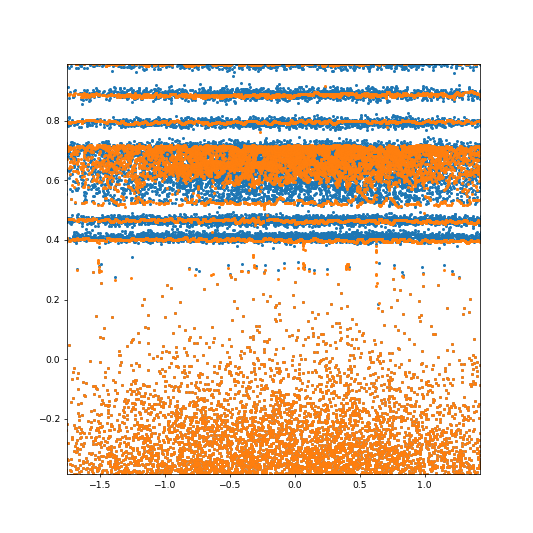

In [551]:
plt.figure(figsize = (8,8))
plt.scatter(test_data[:,0], test_data[:,1], s =5)
#plt.scatter(out_data[:,0], out_data[:,1], s =10)
plt.scatter(v[:,0], v[:,1], s =5)

In [670]:
rv = np.concatenate([(v[:,0]/200)[:,None], v[:,1][:,None]], axis = 1)

In [671]:
rv.shape

(87320, 2)

<IPython.core.display.Javascript object>


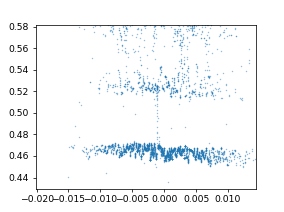

(-1.0, 1.0)

In [672]:
plt.figure()
plt.scatter(rv[:,0], rv[:,1], s = 0.25, alpha = 0.5)
plt.xlim([-1,1])

In [673]:
from sklearn.cluster import DBSCAN

In [674]:
c = DBSCAN(0.01, min_samples=5).fit_predict(rv)

<IPython.core.display.Javascript object>


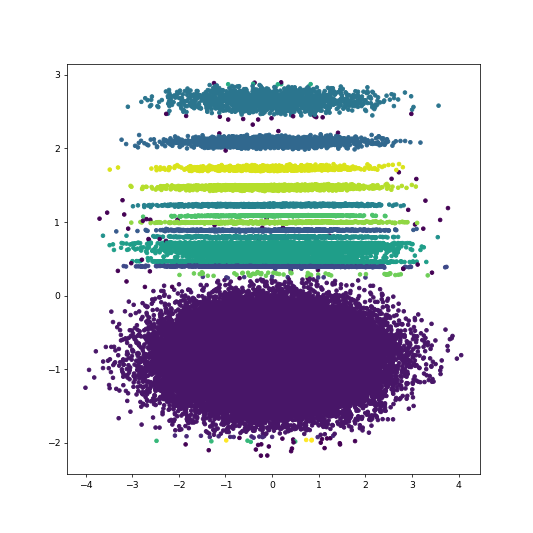

In [675]:
plt.figure(figsize = (8,8))
plt.scatter(v[:,0], v[:,1], s =15, c = c)

<IPython.core.display.Javascript object>


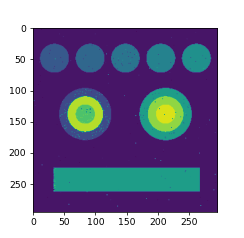

In [676]:
plt.figure()
plt.imshow(c.reshape(sample.raw_data.data.shape[0:2]))

In [677]:
np.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/LatentEncodings/refine_enc_positions4.npy', rv)

In [ ]:
maps = [np.load(f'/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/precip_map_{i}.npy') for i in [8,9,10,11,12,13]]

In [ ]:
map1 = np.load('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/precip_map_19.npy')

In [ ]:
map2 = np.load('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/precip_map_10.npy')

In [ ]:
map3 = np.load('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/precip_map_11.npy')

In [ ]:
def bayesian_conf(maps, pix, pdf_res=50):
    bpdf = np.ones((maps[0].size, pdf_res))

    for emap in maps:
        val = emap[pix[0], pix[1]]
        cpdf = np.repeat(np.linspace(0, 1, pdf_res)[None, :], maps[0].size, axis = 0)
        cpdf[np.where(flatten_nav(emap)==val)] = np.linspace(1, 0, pdf_res)
        bpdf = bpdf*cpdf
    bpdf = bpdf/np.sum(bpdf, axis =1)[:,None]

    return np.mean(bpdf * np.linspace(1,0,pdf_res)[None, :], axis = 1).reshape(maps[0].shape), bpdf

In [ ]:
maps = [np.load(f'/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/precip_map_{i}.npy') for i in range(2, 20)]
pdf_res = 50

In [ ]:
pix = (252,37)

In [ ]:
bconf, bpdf = bayesian_conf(maps, pix, pdf_res)

In [ ]:
plt.figure()
plt.imshow(bconf)

In [ ]:
plt.figure()
plt.imshow(np.where(bconf > 0.01, 1, 0))

In [ ]:
def get_bayes_mask_mean(sample, mask):
    return np.mean(flatten_nav(sample.raw_data.data)[np.where(flatten_nav(mask) == 1)], axis = 0)

In [ ]:
mpat = get_bayes_mask_mean(sample, np.where(bconf > 0.01, 1, 0))

In [ ]:
plt.figure()
plt.imshow(mpat)

In [ ]:
conf = get_confidence_from_maps(maps)


In [ ]:
import palettable
import matplotlib.colors as mcolors

# Given colormap which takes values from 0→50
colors1 = palettable.colorbrewer.sequential.YlGn_9.mpl_colormap(np.linspace(0, 1, 256))
colors1[0] = [0.,0.,0.,1.]
# generating a smoothly-varying LinearSegmentedColormap
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors1)

In [ ]:
plt.figure()
plt.imshow(conf.reshape((512,512)), cmap= cmap, interpolation = 'nearest')
plt.colorbar()

In [ ]:
conf_pd = 1- conf

In [ ]:
class_sizes = {}
for uind in np.unique(map3):
    class_sizes[uind] = np.sum(np.where(map3==uind,1, 0))

In [ ]:
blank = np.zeros_like(map3)
for k,v in class_sizes.items():
    total = map3.size 
    p = v/total
    blank = blank+ np.where(map3 == k, p, 0)

In [ ]:
class_pd = blank

In [ ]:
class_pd = class_pd/class_pd.sum()

In [ ]:
ones = np.ones_like(class_pd).astype('float64')

In [ ]:
test = ones - class_pd

In [ ]:
test = test/ test.sum()

In [ ]:
combined_pd = test*conf_pd

In [ ]:
combined_pd = combined_pd/ combined_pd.sum()

In [ ]:
plt.figure()
plt.imshow(test*conf_pd)

In [ ]:
def resample(sample, n_samples, pd):
    inds = np.arange(sample.raw_data.data[:,:,0,0].size)
    if pd.sum() > 1:
        pd = pd/pd.sum()
    return np.random.choice(inds, n_samples, True, pd)

In [ ]:
rs_inds = resample(sample, 100000, flatten_nav(combined_pd))

In [ ]:
np.save('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/conf_refined_ts2.npy', rs_inds)

In [ ]:
blank = np.zeros(sample.raw_data.data[:,:,0,0].size)
for rsi in rs_inds:
    blank[rsi] += 1
blank = blank.reshape(sample.raw_data.data.shape[0:2])

In [ ]:
plt.figure()
plt.imshow(blank)

In [ ]:
np.log(1.2)

In [ ]:
plt.figure()
plt.hist(conf, 100)

In [ ]:
import palettable
import matplotlib.colors as mcolors

In [ ]:
# Given colormap which takes values from 0→50
colors1 = palettable.colorbrewer.sequential.YlGn_9.mpl_colormap(np.linspace(0, 1, 256))
colors1[0] = [0.,0.,0.,1.]
# generating a smoothly-varying LinearSegmentedColormap
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors1)

In [ ]:
colors1[0]

In [ ]:
np.unique(map1)

In [ ]:
map1_conf_reg = [(np.where(map1 == uind,1,0) * conf).reshape((512,512)) for uind in np.unique(map1)]

In [ ]:
mean_conf = [np.sum(map1_conf_reg[i])/ np.sum(np.where(map1_conf_reg[i]!= 0, 1, 0)) for i in range(len(map1_conf_reg))]

In [ ]:
np.flip(np.argsort(mean_conf))

In [ ]:
map1.min()

In [ ]:
for b in np.flip(np.argsort(mean_conf))[:20]:
    plt.figure()
    plt.imshow((np.where(map1 == b,1,0) * conf).reshape((512,512)), cmap= cmap, interpolation = 'nearest')
    plt.colorbar()
    plt.clim(0,1)
    plt.title(f'{b}: {mean_conf[b]}')

In [ ]:
map1 = np.load('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/precip_map_19.npy')

In [ ]:
sample.all_maps['refine1'] = map1.reshape((512,512)).astype('int') +1

In [ ]:
sample.get_map_patterns('refine1', method = 'mean', recompute=True)

In [ ]:
sample.all_maps['refine1'].min()

In [ ]:
### View the patterns and their associated regions

show_cluster_patterns(sample, 'refine1').plot()

In [ ]:
def get_individual_precip_patterns(sample, maptag, map_index):
    cmap = sample.all_maps[maptag]
    cpatt = sample.all_patterns[maptag][map_index]

    from sklearn.cluster import DBSCAN

    precip_loc = np.where(cmap == map_index+cmap.min())
    indi_precip = DBSCAN(eps  = 2 , min_samples = 2).fit_predict(np.asarray(precip_loc).T)

    return [sample.raw_data.data[tuple(np.asarray(precip_loc).T[np.where(indi_precip == u)][0].T)].compute() for u in np.unique(indi_precip)]

In [ ]:
indi_precip_patts = get_individual_precip_patterns(sample, 'refine1', 33)

In [ ]:
for ipp in indi_precip_patts:
    plt.figure()
    plt.imshow(ipp[64:-64, 64:-64])

In [ ]:
### View a signal boosted representation of the sample

sbs = signal_boosted_scan(sample, 'refine1')

sbs.plot()

In [ ]:
unique_regions = [np.asarray(np.where(sample.all_maps['refine1'] == x))[:,0] for x in np.unique(sample.all_maps['refine1'])]

f = inv_sbs(sbs, tag='refine1', return_fig=True, vmax = 0.5)

In [ ]:
figp = '/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/4Mx-Patterns'

In [ ]:
time_stamp = str(dp).split('/')[-2]

In [ ]:
for i, ur in enumerate(unique_regions):
    f = inv_sbs(sbs,'refine1', ur, return_fig=True, vmax = 0.5)
    f.savefig(str(figp)+f'/{time_stamp}-region-{i}-vmax0.01.jpg', dpi = 200)

## Latwarp Figure

In [ ]:
grid = get_latgrid(sample, 100)

In [ ]:
ingrid = get_latgrid_free(sample, -1.5, -0.5, 0.5,1.5, 50)

In [ ]:
fgrid = flatten_nav(grid)
fingrid = flatten_nav(ingrid)

In [ ]:
c = np.linalg.norm(fgrid - np.array((0,0)), axis = 1)
cin = np.linalg.norm(fingrid - np.array((0,0)), axis = 1)
cin /= c.max()
c /= c.max()

In [ ]:
tdata = test_data
tdata1 = rand_tform2.inverse(tdata)
tdata2 = rand_tform2.inverse(tdata1)
tgrid = rand_tform2.inverse(fgrid)
tingrid = rand_tform2.inverse(fingrid)


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(tdata[:,0], tdata[:,1], s =10, c='black')
ax.scatter(fgrid[:,0], fgrid[:,1], s =10, c = c, alpha = 0.5, vmin=0, vmax=1)
axins = inset_axes(ax,width = '40%', height = '40%')
axins.scatter(tdata[:,0], tdata[:,1], s =40, c='black')
axins.scatter(fingrid[:,0], fingrid[:,1], s =10, c = cin, alpha = 0.25, vmin=0, vmax=1)
axins.set_xlim([-1.5, -0.5])
axins.set_ylim([0.5, 1.5])


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(tdata1[:,0], tdata1[:,1], s =10, c='black')
ax.scatter(tgrid[:,0], tgrid[:,1], s =10, c = c, alpha = 0.5, vmin=0, vmax=1)
axins = inset_axes(ax,width = '40%', height = '40%')
axins.scatter(tdata1[:,0], tdata1[:,1], s =40, c='black')
axins.scatter(tingrid[:,0], tingrid[:,1], s =10, c = cin, alpha = 0.15, vmin=0, vmax=1)
axins.set_xlim([-1.5, -0.5])
axins.set_ylim([0.5, 1.5])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(tdata1[:,0], tdata1[:,1], s =10, c='black')
ax.scatter(fgrid[:,0], fgrid[:,1], s =10, c = c, alpha = 0.5, vmin=0, vmax=1)
axins = inset_axes(ax,width = '40%', height = '40%')
axins.scatter(tdata1[:,0], tdata1[:,1], s =40, c='black')
axins.scatter(fingrid[:,0], fingrid[:,1], s =10, c = cin, alpha = 0.25, vmin=0, vmax=1)
axins.set_xlim([-1, 1])
axins.set_ylim([-1, 1])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(tdata2[:,0], tdata2[:,1], s =10, c='black')
ax.scatter(tgrid[:,0], tgrid[:,1], s =10, c = c, alpha = 0.5, vmin=0, vmax=1)
axins = inset_axes(ax,width = '40%', height = '40%')
axins.scatter(tdata2[:,0], tdata2[:,1], s =40, c='black')
axins.scatter(tingrid[:,0], tingrid[:,1], s =10, c = cin, alpha = 0.25, vmin=0, vmax=1)
axins.set_xlim([-1, 1])
axins.set_ylim([-1, 1])